In [2]:
from langchain_core.messages import HumanMessage
from toolkits import *
from agents import *

In [3]:
agents = RoomAppointmentAgents()
app = agents.workflow()
graph = app.get_graph()
print(graph)


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'user_info_node': Node(id='user_info_node', name='user_info_node', data=user_info_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='supervisor', data=Non

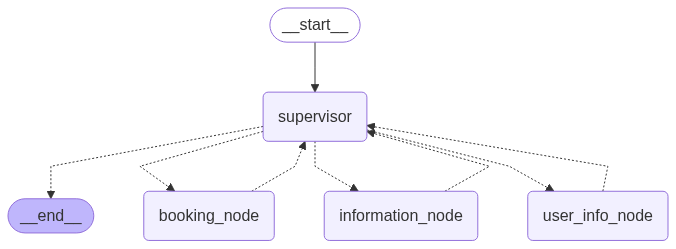

In [4]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [5]:

user_data = {'customer_name':'Abdelrhman', 'customer_id':'8990'}


inputs = [

        HumanMessage(content=f'cancel my last booking')
]
state = {'messages': inputs,**user_data}

# 9774,1,Abdelrhman,8990,2025-05-22 07:00,2025-05-22 09:00


In [6]:
result = app.invoke(state)
print("\n--- Final State ---")
print(result)


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='cancel my last booking', additional_kwargs={}, response_metadata={}, id='731836b9-7081-4142-a95d-7b141a1d95d1')], 'customer_id': '8990', 'customer_name': 'Abdelrhman'}
***********************this is my message for LLM*****************************************
[SystemMessage(content='You\'re an intelligent supervisor for a Meeting Room Management System. Current date and time: 2025-05-22 14:21:19 (Thursday).\n Your role is to:\n 1. Analyze user queries to determine their intent\n 2. Route requests to the appropriate specialized agent\n 3. Synthesize information from different agents into cohesive responses\n 4. Handle conversational context and memory\n 5. Maintain user identity information (user ID and name)\n 6. Determine if the user\'s request has been fully addressed and if the conversation can end\n 7. If an agent has provided a response that fully answers